In [17]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy import stats
warnings.filterwarnings('ignore') #(action='once')

## Task 1

Implement the basic model with a von Neumann neighbourhood and parameters N = 10000, c max =0.5, p + = 0.8. Come up with at least three global observables that characterize the population as a whole and that change in time, discuss their time evolution and visualize the dynamics of the system

In [18]:
# Helper function to get neighbors
def get_Von_Neumann_neighbourhood(x, y, grid, grid_size):
    left = (x-1) % grid_size, y
    right = (x+1) % grid_size, y
    bottom = x, (y-1) % grid_size
    top = x, (y+1) % grid_size
    return [grid[left], grid[right], grid[bottom], grid[top]]

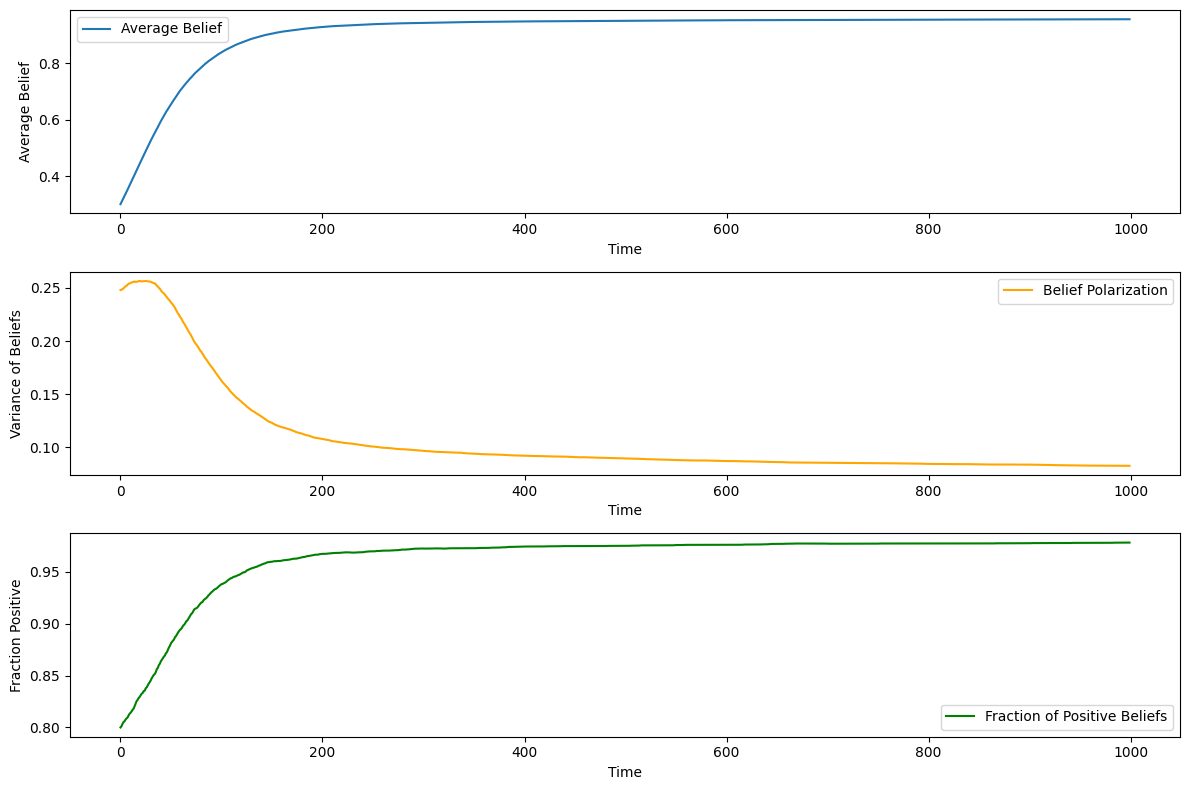

In [19]:
# Set parameters according to Task 1
N = 10000
grid_size = int(np.sqrt(N))
c_max = 0.5
p_plus = 0.8

# Initialize beliefs grid
beliefs_grid = np.zeros((grid_size, grid_size))

# Initialize convincing power grid
convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

# Assign initial beliefs
positive_fraction = int(N * p_plus)
negative_fraction = N - positive_fraction
beliefs_grid.flat[:positive_fraction] = np.random.uniform(0, 1, positive_fraction)
beliefs_grid.flat[positive_fraction:] = np.random.uniform(-1, 0, negative_fraction)
np.random.shuffle(beliefs_grid.flat)

# Simulation
timesteps = 1000

average_beliefs = []
belief_variances = []
positive_belief_fractions = []

for i in range(timesteps):
    # Record global observables
    average_beliefs.append(np.mean(beliefs_grid))
    belief_variances.append(np.var(beliefs_grid))
    positive_belief_fractions.append(np.mean(beliefs_grid > 0))

   # Update beliefs
    for _ in range(N // 10):  # Update 10% of the population
        x, y = np.random.randint(0, grid_size, size=2)
        neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
        neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
        beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
        beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

# Visualization
time = np.arange(timesteps)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, average_beliefs, label='Average Belief')
plt.xlabel('Time')
plt.ylabel('Average Belief')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, belief_variances, label='Belief Polarization', color='orange')
plt.xlabel('Time')
plt.ylabel('Variance of Beliefs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, positive_belief_fractions, label='Fraction of Positive Beliefs', color='green')
plt.xlabel('Time')
plt.ylabel('Fraction Positive')
plt.legend()

plt.tight_layout()
plt.show()

## Task 2

Introduce trolls into the model. They are characterized by their belief in the fake news b i = −1, which does not change. Find which fraction of the population needs to be trolls, such that more than half of the normal population (non-trolls) have a belief b i < 0 after 3000 timesteps.

In [20]:
def run_simulation(troll_fraction, timesteps=3000):
    # Parameters
    N = 10000
    grid_size = int(np.sqrt(N))
    c_max = 0.5
    p_plus = 0.8

    # Initialize grids
    beliefs_grid = np.zeros((grid_size, grid_size))
    convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

    # Create troll mask (True for troll positions)
    num_trolls = int(N * troll_fraction)
    troll_indices = np.random.choice(N, num_trolls, replace=False)
    troll_mask = np.zeros(N, dtype=bool)
    troll_mask[troll_indices] = True
    troll_mask = troll_mask.reshape(grid_size, grid_size)

    # Calculate number of non-trolls
    num_non_trolls = N - num_trolls

    # Initialize beliefs for non-trolls
    positive_fraction = int(num_non_trolls * p_plus)
    negative_fraction = num_non_trolls - positive_fraction

    # Create non-troll beliefs array
    non_troll_beliefs = np.concatenate([
        np.random.uniform(0, 1, positive_fraction),
        np.random.uniform(-1, 0, negative_fraction)
    ])
    np.random.shuffle(non_troll_beliefs)

    # Initialize all beliefs to non-troll values
    beliefs_flat = beliefs_grid.ravel()
    beliefs_flat[~troll_mask.ravel()] = non_troll_beliefs
    beliefs_grid = beliefs_flat.reshape(grid_size, grid_size)

    # Set troll beliefs to -1
    beliefs_grid[troll_mask] = -1

    # Simulation
    for _ in range(timesteps):
        # Update beliefs
        for _ in range(N // 10):  # Update 10% of the population
            x, y = np.random.randint(0, grid_size, size=2)

            # Skip if position is a troll
            if troll_mask[x, y]:
                continue

            neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
            neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
            beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
            beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

    # Calculate final statistics for non-trolls only
    non_troll_beliefs = beliefs_grid[~troll_mask]
    negative_belief_fraction = np.mean(non_troll_beliefs < 0)

    return negative_belief_fraction

In [21]:
#troll_fractions = np.linspace(0, 1, 10)
#
#for fraction in troll_fractions:
#    negative_fraction = run_simulation(fraction)
#    print(f"Testing troll fraction {fraction:.3f}: negative belief fraction = {negative_fraction:.3f}")
#    if negative_fraction > 0.5:
#        break

In [22]:
def test_troll_fraction(troll_fraction, num_trials=10, confidence_level=0.95):
    """Run multiple trials and return statistical measures"""
    results = [run_simulation(troll_fraction) for _ in range(num_trials)]

    mean = np.mean(results)
    std = np.std(results, ddof=1)  # Sample standard deviation
    sem = std / np.sqrt(num_trials)  # Standard error of the mean

    # Calculate confidence interval
    ci = stats.t.interval(confidence_level, len(results)-1, loc=mean, scale=sem)

    return {
        'mean': mean,
        'std': std,
        'ci_lower': ci[0],
        'ci_upper': ci[1]
    }

def find_critical_troll_fraction(tolerance=0.01, num_trials=10, confidence_level=0.95):
    left = 0
    right = 0.5  # Start with max 50% trolls
    target = 0.5  # We want more than half of non-trolls to have negative beliefs

    max_iterations = 20  # Prevent infinite loops
    iteration = 0

    best_fraction = None
    best_stats = None

    while right - left > tolerance and iteration < max_iterations:
        mid = (left + right) / 2
        stats = test_troll_fraction(mid, num_trials, confidence_level)

        print(f"\nTesting troll fraction {mid:.3f}:")
        print(f"Mean negative belief fraction: {stats['mean']:.3f}")
        print(f"95% CI: [{stats['ci_lower']:.3f}, {stats['ci_upper']:.3f}]")
        print(f"Standard deviation: {stats['std']:.3f}")

        # update best it's closest to target
        if best_fraction is None or abs(stats['mean'] - target) < abs(best_stats['mean'] - target) and (stats['mean'] - target) > 0 and (stats['ci_lower'] > (target- 0.02)):
            best_fraction = mid
            best_stats = stats

        # Update critical fraction to test by using lower ci
        if stats['ci_lower'] > target:
            right = mid
        else:
            left = mid

        iteration += 1

    return best_fraction, best_stats

# Find the critical troll fraction with statistical testing
print("Finding critical troll fraction...")
critical_fraction, final_stats = find_critical_troll_fraction(
    tolerance=0.01,
    num_trials=10,
    confidence_level=0.95
)

print("\nFinal Results:")
print(f"Critical troll fraction: {critical_fraction:.3f}")
print(f"Mean negative belief fraction: {final_stats['mean']:.3f}")
print(f"95% Confidence Interval: [{final_stats['ci_lower']:.3f}, {final_stats['ci_upper']:.3f}]")
print(f"Standard deviation: {final_stats['std']:.3f}")

Finding critical troll fraction...

Testing troll fraction 0.250:
Mean negative belief fraction: 0.622
95% CI: [0.612, 0.633]
Standard deviation: 0.014

Testing troll fraction 0.125:
Mean negative belief fraction: 0.282
95% CI: [0.275, 0.290]
Standard deviation: 0.011

Testing troll fraction 0.188:
Mean negative belief fraction: 0.458
95% CI: [0.450, 0.466]
Standard deviation: 0.011

Testing troll fraction 0.219:
Mean negative belief fraction: 0.553
95% CI: [0.541, 0.565]
Standard deviation: 0.017

Testing troll fraction 0.203:
Mean negative belief fraction: 0.499
95% CI: [0.490, 0.508]
Standard deviation: 0.013

Testing troll fraction 0.211:
Mean negative belief fraction: 0.529
95% CI: [0.522, 0.535]
Standard deviation: 0.009

Final Results:
Critical troll fraction: 0.211
Mean negative belief fraction: 0.529
95% Confidence Interval: [0.522, 0.535]
Standard deviation: 0.009


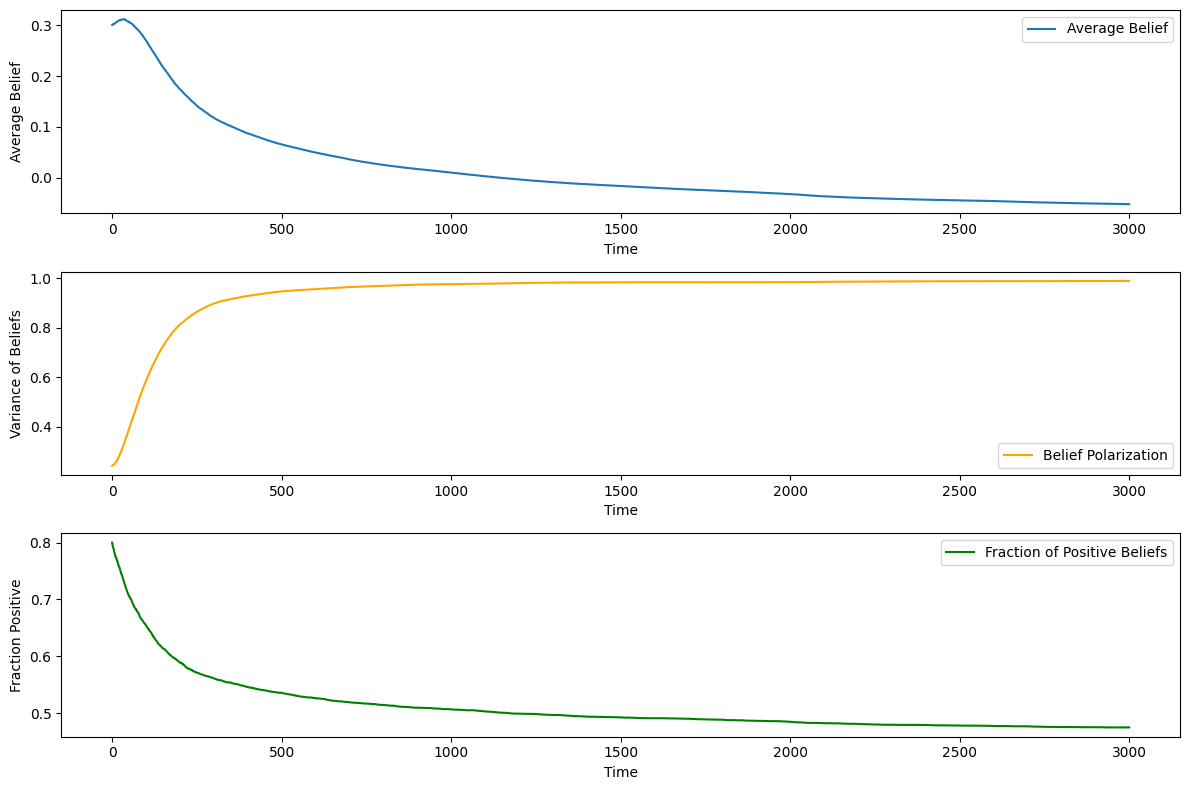

In [23]:
average_beliefs = []
belief_variances = []
positive_belief_fractions = []

# Parameters
N = 10000
grid_size = int(np.sqrt(N))
c_max = 0.5
p_plus = 0.8

troll_fraction = critical_fraction
timesteps = 3000

# Initialize grids
beliefs_grid = np.zeros((grid_size, grid_size))
convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

# Create troll mask (True for troll positions)
num_trolls = int(N * troll_fraction)
troll_indices = np.random.choice(N, num_trolls, replace=False)
troll_mask = np.zeros(N, dtype=bool)
troll_mask[troll_indices] = True
troll_mask = troll_mask.reshape(grid_size, grid_size)

# Calculate number of non-trolls
num_non_trolls = N - num_trolls

# Initialize beliefs for non-trolls
positive_fraction = int(num_non_trolls * p_plus)
negative_fraction = num_non_trolls - positive_fraction

# Create non-troll beliefs array
non_troll_beliefs = np.concatenate([
    np.random.uniform(0, 1, positive_fraction),
    np.random.uniform(-1, 0, negative_fraction)
])
np.random.shuffle(non_troll_beliefs)

# Initialize all beliefs to non-troll values
beliefs_flat = beliefs_grid.ravel()
beliefs_flat[~troll_mask.ravel()] = non_troll_beliefs
beliefs_grid = beliefs_flat.reshape(grid_size, grid_size)

# Set troll beliefs to -1
beliefs_grid[troll_mask] = -1

# Simulation
for _ in range(timesteps):

    # Record global observables for non-trolls only
    non_troll_beliefs = beliefs_grid[~troll_mask]
    average_beliefs.append(np.mean(non_troll_beliefs))
    belief_variances.append(np.var(non_troll_beliefs))
    positive_belief_fractions.append(np.mean(non_troll_beliefs > 0))

    # Update beliefs
    for _ in range(N // 10):  # Update 10% of the population
        x, y = np.random.randint(0, grid_size, size=2)

        # Skip if position is a troll
        if troll_mask[x, y]:
            continue

        neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
        neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
        beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
        beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)



# Visualization
time = np.arange(timesteps)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, average_beliefs, label='Average Belief')
plt.xlabel('Time')
plt.ylabel('Average Belief')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, belief_variances, label='Belief Polarization', color='orange')
plt.xlabel('Time')
plt.ylabel('Variance of Beliefs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, positive_belief_fractions, label='Fraction of Positive Beliefs', color='green')
plt.xlabel('Time')
plt.ylabel('Fraction Positive')
plt.legend()

plt.tight_layout()
plt.show()

Task 3

Discuss changes in the dynamics when you change the initial parameters or increase the number of neighbours. Also discuss changes, when the part of the population with beliefs bi < 0 is concentrated in some region of the grid initially.

Finding critical troll fraction...

Testing troll fraction 0.250:
Mean negative belief fraction: 0.221
95% CI: [0.220, 0.223]
Standard deviation: 0.002

Testing troll fraction 0.375:
Mean negative belief fraction: 0.247
95% CI: [0.246, 0.249]
Standard deviation: 0.003

Testing troll fraction 0.438:
Mean negative belief fraction: 0.262
95% CI: [0.260, 0.264]
Standard deviation: 0.003

Testing troll fraction 0.469:
Mean negative belief fraction: 0.271
95% CI: [0.268, 0.274]
Standard deviation: 0.004

Testing troll fraction 0.484:
Mean negative belief fraction: 0.272
95% CI: [0.270, 0.275]
Standard deviation: 0.004

Testing troll fraction 0.492:
Mean negative belief fraction: 0.274
95% CI: [0.272, 0.276]
Standard deviation: 0.003

Final Results:
Critical troll fraction: 0.250
Mean negative belief fraction: 0.221
95% Confidence Interval: [0.220, 0.223]
Standard deviation: 0.002

Testing grid size 100, c_max 0.3, p_plus 0.6:

Testing troll fraction 0.250:
Mean negative belief fraction: 0.41

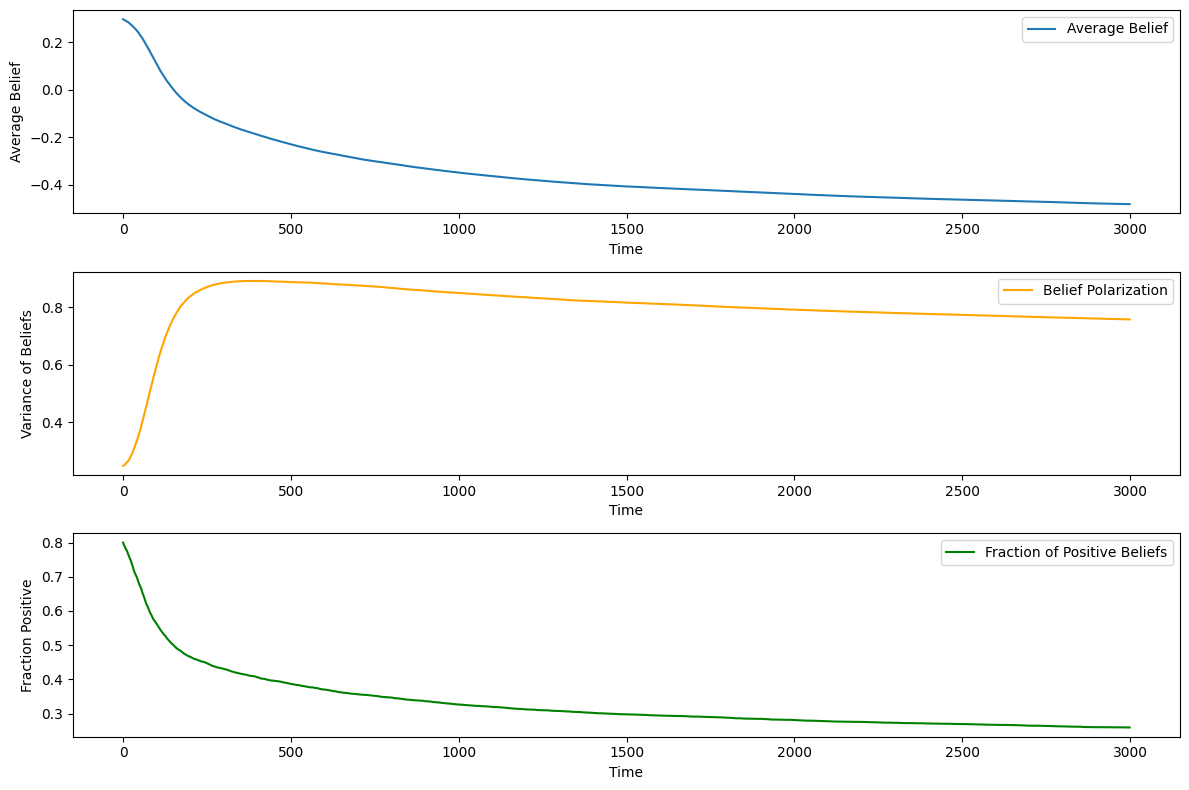

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def get_Von_Neumann_neighbourhood(x, y, grid, grid_size):
    """Return the Von Neumann neighbourhood of a grid position."""
    neighbours = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                neighbours.append((nx, ny))
    return [grid[nx, ny] for nx, ny in neighbours]

def run_simulation(troll_fraction, grid_size, c_max, p_plus, region=None, timesteps=3000):
    N = grid_size ** 2
    # Initialize grids
    beliefs_grid = np.zeros((grid_size, grid_size))
    convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

    # Create troll mask (True for troll positions)
    num_trolls = int(N * troll_fraction)
    troll_indices = np.random.choice(N, num_trolls, replace=False)
    troll_mask = np.zeros(N, dtype=bool)
    troll_mask[troll_indices] = True
    troll_mask = troll_mask.reshape(grid_size, grid_size)

    # Initialize beliefs for non-trolls
    positive_fraction = int((N - num_trolls) * p_plus)
    negative_fraction = (N - num_trolls) - positive_fraction

    # Create non-troll beliefs array
    non_troll_beliefs = np.concatenate([
        np.random.uniform(0, 1, positive_fraction),
        np.random.uniform(-1, 0, negative_fraction)
    ])
    np.random.shuffle(non_troll_beliefs)

    # Initialize all beliefs to non-troll values
    beliefs_flat = beliefs_grid.ravel()
    beliefs_flat[~troll_mask.ravel()] = non_troll_beliefs
    beliefs_grid = beliefs_flat.reshape(grid_size, grid_size)

    # Set troll beliefs to -1
    beliefs_grid[troll_mask] = -1

    # Set initial beliefs for a specific region if needed
    if region:
        region_start = region[0]
        region_end = region[1]
        beliefs_grid[region_start[0]:region_end[0], region_start[1]:region_end[1]] = -1

    # Simulation
    for _ in range(timesteps):
        # Update beliefs
        for _ in range(N // 10):  # Update 10% of the population
            x, y = np.random.randint(0, grid_size, size=2)

            # Skip if position is a troll
            if troll_mask[x, y]:
                continue

            neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
            neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
            beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
            beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

    # Calculate final statistics for non-trolls only
    non_troll_beliefs = beliefs_grid[~troll_mask]
    negative_belief_fraction = np.mean(non_troll_beliefs < 0)

    return negative_belief_fraction

def test_troll_fraction(troll_fraction, grid_size, c_max, p_plus, region=None, num_trials=10, confidence_level=0.95):
    """Run multiple trials and return statistical measures"""
    results = [run_simulation(troll_fraction, grid_size, c_max, p_plus, region, num_trials) for _ in range(num_trials)]

    mean = np.mean(results)
    std = np.std(results, ddof=1)  # Sample standard deviation
    sem = std / np.sqrt(num_trials)  # Standard error of the mean

    # Calculate confidence interval
    ci = stats.t.interval(confidence_level, len(results)-1, loc=mean, scale=sem)

    return {
        'mean': mean,
        'std': std,
        'ci_lower': ci[0],
        'ci_upper': ci[1]
    }

def find_critical_troll_fraction(grid_size, c_max, p_plus, region=None, tolerance=0.01, num_trials=10, confidence_level=0.95):
    left = 0
    right = 0.5  # Start with max 50% trolls
    target = 0.5  # We want more than half of non-trolls to have negative beliefs

    max_iterations = 20  # Prevent infinite loops
    iteration = 0

    best_fraction = None
    best_stats = None

    while right - left > tolerance and iteration < max_iterations:
        mid = (left + right) / 2
        stats = test_troll_fraction(mid, grid_size, c_max, p_plus, region, num_trials, confidence_level)

        print(f"\nTesting troll fraction {mid:.3f}:")
        print(f"Mean negative belief fraction: {stats['mean']:.3f}")
        print(f"95% CI: [{stats['ci_lower']:.3f}, {stats['ci_upper']:.3f}]")
        print(f"Standard deviation: {stats['std']:.3f}")

        # update best it's closest to target
        if best_fraction is None or abs(stats['mean'] - target) < abs(best_stats['mean'] - target) and (stats['mean'] - target) > 0 and (stats['ci_lower'] > (target- 0.02)):
            best_fraction = mid
            best_stats = stats

        # Update critical fraction to test by using lower ci
        if stats['ci_lower'] > target:
            right = mid
        else:
            left = mid

        iteration += 1

    return best_fraction, best_stats

# Find the critical troll fraction with statistical testing
print("Finding critical troll fraction...")
critical_fraction, final_stats = find_critical_troll_fraction(
    grid_size=100,
    c_max=0.5,
    p_plus=0.8,
    tolerance=0.01,
    num_trials=10,
    confidence_level=0.95
)

print("\nFinal Results:")
print(f"Critical troll fraction: {critical_fraction:.3f}")
print(f"Mean negative belief fraction: {final_stats['mean']:.3f}")
print(f"95% Confidence Interval: [{final_stats['ci_lower']:.3f}, {final_stats['ci_upper']:.3f}]")
print(f"Standard deviation: {final_stats['std']:.3f}")

# Test different grid sizes and conviction powers
grid_sizes = [100, 200, 300]
c_maxs = [0.3, 0.5, 0.7]
p_pluss = [0.6, 0.7, 0.8]

for grid_size in grid_sizes:
    for c_max in c_maxs:
        for p_plus in p_pluss:
            print(f"\nTesting grid size {grid_size}, c_max {c_max}, p_plus {p_plus}:")
            critical_fraction, final_stats = find_critical_troll_fraction(
                grid_size=grid_size,
                c_max=c_max,
                p_plus=p_plus,
                tolerance=0.01,
                num_trials=10,
                confidence_level=0.95
            )
            print(f"Critical troll fraction: {critical_fraction:.3f}")
            print(f"Mean negative belief fraction: {final_stats['mean']:.3f}")
            print(f"95% Confidence Interval: [{final_stats['ci_lower']:.3f}, {final_stats['ci_upper']:.3f}]")
            print(f"Standard deviation: {final_stats['std']:.3f}")

# Test different initial belief distributions
initial_conditions = [
    {'p_plus': 0.8, 'region': None},
    {'p_plus': 0.2, 'region': None},
    {'p_plus': 0.8, 'region': ((1, 1), (10, 10))},
    {'p_plus': 0.8, 'region': ((grid_size//2, grid_size//2), (grid_size//2+10, grid_size//2+10))}
]

for condition in initial_conditions:
    print(f"\nTesting initial condition: {condition}")
    critical_fraction, final_stats = find_critical_troll_fraction(
        grid_size=100,
        c_max=0.5,
        p_plus=condition['p_plus'],
        region=condition['region'],
        tolerance=0.01,
        num_trials=10,
        confidence_level=0.95
    )
    print(f"Critical troll fraction: {critical_fraction:.3f}")
    print(f"Mean negative belief fraction: {final_stats['mean']:.3f}")
    print(f"95% Confidence Interval: [{final_stats['ci_lower']:.3f}, {final_stats['ci_upper']:.3f}]")
    print(f"Standard deviation: {final_stats['std']:.3f}")

# Visualization for one specific condition
grid_size = 100
c_max = 0.5
p_plus = 0.8
troll_fraction = critical_fraction
timesteps = 3000

average_beliefs = []
belief_variances = []
positive_belief_fractions = []

# Initialize grids
beliefs_grid = np.zeros((grid_size, grid_size))
convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

# Create troll mask (True for troll positions)
num_trolls = int(grid_size ** 2 * troll_fraction)
troll_indices = np.random.choice(grid_size ** 2, num_trolls, replace=False)
troll_mask = np.zeros(grid_size ** 2, dtype=bool)
troll_mask[troll_indices] = True
troll_mask = troll_mask.reshape(grid_size, grid_size)

# Initialize beliefs for non-trolls
positive_fraction = int((grid_size ** 2 - num_trolls) * p_plus)
negative_fraction = (grid_size ** 2 - num_trolls) - positive_fraction

# Create non-troll beliefs array
non_troll_beliefs = np.concatenate([
    np.random.uniform(0, 1, positive_fraction),
    np.random.uniform(-1, 0, negative_fraction)
])
np.random.shuffle(non_troll_beliefs)

# Initialize all beliefs to non-troll values
beliefs_flat = beliefs_grid.ravel()
beliefs_flat[~troll_mask.ravel()] = non_troll_beliefs
beliefs_grid = beliefs_flat.reshape(grid_size, grid_size)

# Set troll beliefs to -1
beliefs_grid[troll_mask] = -1

# Simulation
for _ in range(timesteps):
    # Record global observables for non-trolls only
    non_troll_beliefs = beliefs_grid[~troll_mask]
    average_beliefs.append(np.mean(non_troll_beliefs))
    belief_variances.append(np.var(non_troll_beliefs))
    positive_belief_fractions.append(np.mean(non_troll_beliefs > 0))

    # Update beliefs
    for _ in range(grid_size ** 2 // 10):  # Update 10% of the population
        x, y = np.random.randint(0, grid_size, size=2)

        # Skip if position is a troll
        if troll_mask[x, y]:
            continue

        neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
        neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
        beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
        beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

# Visualization
time = np.arange(timesteps)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, average_beliefs, label='Average Belief')
plt.xlabel('Time')
plt.ylabel('Average Belief')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, belief_variances, label='Belief Polarization', color='orange')
plt.xlabel('Time')
plt.ylabel('Variance of Beliefs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, positive_belief_fractions, label='Fraction of Positive Beliefs', color='green')
plt.xlabel('Time')
plt.ylabel('Fraction Positive')
plt.legend()

plt.tight_layout()
plt.show()

Task4

Come up with a mechanism to counter the trolls in this model and implement it. Also discuss further possible extensions and shortcomings of this model.

To counteract network trolls in the model, we can design a reputation-based scoring mechanism. The core idea of this mechanism is to assign a reputation score to each individual (including regular users and trolls) based on their historical behavior and interaction records. By doing so, we can identify individuals with abnormal or disruptive behavior patterns, thereby reducing their influence on the model.

Reputation Score Initialization:
Assign an initial reputation score to each individual, such as 0.5.
Scoring Update Rules:
When an individual's belief is influenced by the beliefs of their neighbors, their reputation score increases if their neighbors have high reputation scores.
If an individual is a troll and their beliefs remain fixed, this behavior pattern can be detected, leading to a reduction in their reputation score.
The reputation score ranges from [0, 1], where 1 represents the highest reputation and 0 represents the lowest reputation.

Belief Update Mechanism:
When updating an individual's beliefs, consider the reputation scores of their neighbors. A neighbor's beliefs will only influence the individual if their reputation score exceeds a certain threshold.
Visualization of Reputation Scores:
During the simulation process, the reputation scores of all individuals can be visualized to observe the distribution and impact of trolls in the network.

Finding critical troll fraction...

Testing troll fraction 0.250:
Mean negative belief fraction: 0.786
95% CI: [0.772, 0.801]
Standard deviation: 0.021

Testing troll fraction 0.125:
Mean negative belief fraction: 0.278
95% CI: [0.259, 0.297]
Standard deviation: 0.027

Testing troll fraction 0.188:
Mean negative belief fraction: 0.550
95% CI: [0.534, 0.567]
Standard deviation: 0.023

Testing troll fraction 0.156:
Mean negative belief fraction: 0.421
95% CI: [0.405, 0.438]
Standard deviation: 0.024

Testing troll fraction 0.172:
Mean negative belief fraction: 0.499
95% CI: [0.489, 0.510]
Standard deviation: 0.015

Testing troll fraction 0.180:
Mean negative belief fraction: 0.522
95% CI: [0.509, 0.535]
Standard deviation: 0.018

Final Results:
Critical troll fraction: 0.180
Mean negative belief fraction: 0.522
95% Confidence Interval: [0.509, 0.535]
Standard deviation: 0.018


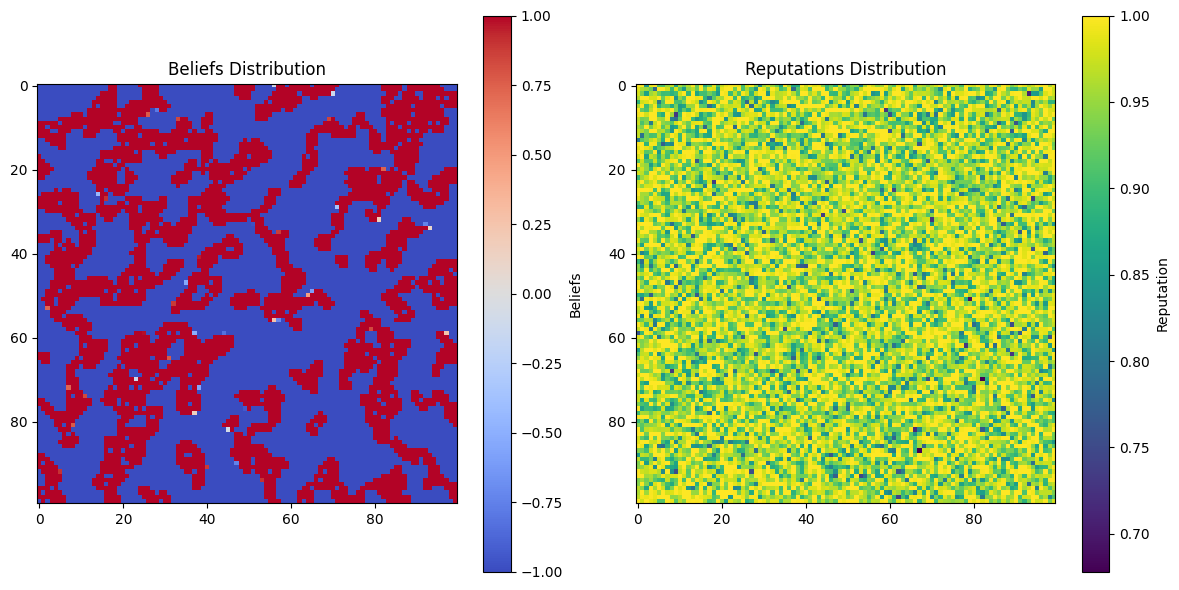

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


def get_Von_Neumann_neighbourhood(x, y, grid, grid_size):
    """Return the Von Neumann neighbourhood coordinates."""
    neighbours = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                neighbours.append((nx, ny))
    return neighbours


def run_simulation(troll_fraction, grid_size, c_max, p_plus, region=None, timesteps=3000):
    N = grid_size ** 2
    # Initialize grids
    beliefs_grid = np.zeros((grid_size, grid_size))
    convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))
    reputations = np.ones((grid_size, grid_size))  # Initialize reputations to 1

    # Create troll mask (True for troll positions)
    num_trolls = int(N * troll_fraction)
    troll_indices = np.random.choice(N, num_trolls, replace=False)
    troll_mask = np.zeros(N, dtype=bool)
    troll_mask[troll_indices] = True
    troll_mask = troll_mask.reshape(grid_size, grid_size)

    # Initialize beliefs for non-trolls
    positive_fraction = int((N - num_trolls) * p_plus)
    negative_fraction = (N - num_trolls) - positive_fraction

    # Create non-troll beliefs array
    non_troll_beliefs = np.concatenate([
        np.random.uniform(0, 1, positive_fraction),
        np.random.uniform(-1, 0, negative_fraction)
    ])
    np.random.shuffle(non_troll_beliefs)

    # Initialize all beliefs to non-troll values
    beliefs_flat = beliefs_grid.ravel()
    beliefs_flat[~troll_mask.ravel()] = non_troll_beliefs
    beliefs_grid = beliefs_flat.reshape(grid_size, grid_size)

    # Set troll beliefs to -1
    beliefs_grid[troll_mask] = -1

    # Set initial beliefs for a specific region if needed
    if region:
        region_start = region[0]
        region_end = region[1]
        beliefs_grid[region_start[0]:region_end[0], region_start[1]:region_end[1]] = -1

    # Simulation
    for _ in range(timesteps):
        # Update beliefs
        for _ in range(N // 10):  # Update 10% of the population
            x, y = np.random.randint(0, grid_size, size=2)

            # Skip if position is a troll
            if troll_mask[x, y]:
                continue

            neighbourhood_b = [beliefs_grid[nx, ny] for nx, ny in get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)]
            neighbourhood_c = [convincing_powers[nx, ny] for nx, ny in get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)]
            neighbourhood_r = [reputations[nx, ny] for nx, ny in get_Von_Neumann_neighbourhood(x, y, reputations, grid_size)]

            weighted_sum = np.sum([b * c * r for b, c, r in zip(neighbourhood_b, neighbourhood_c, neighbourhood_r)])
            weighted_count = np.sum([c * r for c, r in zip(neighbourhood_c, neighbourhood_r)])

            if weighted_count > 0:
                beliefs_grid[x, y] += weighted_sum / weighted_count
                beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

            # Update reputation based on interaction
            for nx, ny in get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size):  # Use beliefs_grid as a placeholder
                if not troll_mask[nx, ny] and np.random.rand() < 0.1:
                    reputation_change = np.random.uniform(-0.01, 0.01)
                    reputations[nx, ny] = np.clip(reputations[nx, ny] + reputation_change, 0, 1)

    # Calculate final statistics for non-trolls only
    non_troll_beliefs = beliefs_grid[~troll_mask]
    negative_belief_fraction = np.mean(non_troll_beliefs < 0)

    return negative_belief_fraction, beliefs_grid, reputations


def test_troll_fraction(troll_fraction, grid_size, c_max, p_plus, region=None, num_trials=10, confidence_level=0.95):
    results = [run_simulation(troll_fraction, grid_size, c_max, p_plus, region, timesteps=3000) for _ in range(num_trials)]
    beliefs_grids = [result[1] for result in results]
    reputations = [result[2] for result in results]

    mean = np.mean([result[0] for result in results])
    std = np.std([result[0] for result in results], ddof=1)  # Sample standard deviation
    sem = std / np.sqrt(num_trials)  # Standard error of the mean

    # Calculate confidence interval
    ci = stats.t.interval(confidence_level, len(results) - 1, loc=mean, scale=sem)

    return {
        'mean': mean,
        'std': std,
        'ci_lower': ci[0],
        'ci_upper': ci[1],
        'beliefs_grids': beliefs_grids,
        'reputations': reputations
    }


def find_critical_troll_fraction(grid_size, c_max, p_plus, region=None, tolerance=0.01, num_trials=10, confidence_level=0.95):
    left = 0
    right = 0.5  # Start with max 50% trolls
    target = 0.5  # We want more than half of non-trolls to have negative beliefs

    max_iterations = 20  # Prevent infinite loops
    iteration = 0

    best_fraction = None
    best_stats = None

    while right - left > tolerance and iteration < max_iterations:
        mid = (left + right) / 2
        stats = test_troll_fraction(mid, grid_size, c_max, p_plus, region, num_trials, confidence_level)

        print(f"\nTesting troll fraction {mid:.3f}:")
        print(f"Mean negative belief fraction: {stats['mean']:.3f}")
        print(f"95% CI: [{stats['ci_lower']:.3f}, {stats['ci_upper']:.3f}]")
        print(f"Standard deviation: {stats['std']:.3f}")

        # Update best fraction if it's closest to the target
        if best_fraction is None or abs(stats['mean'] - target) < abs(best_stats['mean'] - target) and (stats['mean'] - target) > 0 and (stats['ci_lower'] > (target - 0.02)):
            best_fraction = mid
            best_stats = stats

        # Update critical fraction to test by using lower ci
        if stats['ci_lower'] > target:
            right = mid
        else:
            left = mid

        iteration += 1

    return best_fraction, best_stats


# Find the critical troll fraction with statistical testing
print("Finding critical troll fraction...")
critical_fraction, final_stats = find_critical_troll_fraction(
    grid_size=100,
    c_max=0.5,
    p_plus=0.8,
    tolerance=0.01,
    num_trials=10,
    confidence_level=0.95
)

print("\nFinal Results:")
print(f"Critical troll fraction: {critical_fraction:.3f}")
print(f"Mean negative belief fraction: {final_stats['mean']:.3f}")
print(f"95% Confidence Interval: [{final_stats['ci_lower']:.3f}, {final_stats['ci_upper']:.3f}]")
print(f"Standard deviation: {final_stats['std']:.3f}")


# Visualization for one specific condition
grid_size = 100
c_max = 0.5
p_plus = 0.8
troll_fraction = critical_fraction
timesteps = 3000

result = run_simulation(troll_fraction, grid_size, c_max, p_plus, timesteps=timesteps)
beliefs_grid = result[1]
reputations = result[2]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(beliefs_grid, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Beliefs')
plt.title('Beliefs Distribution')

plt.subplot(1, 2, 2)
plt.imshow(reputations, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Reputation')
plt.title('Reputations Distribution')

plt.tight_layout()
plt.show()